Задача: на датасете DesktopCO проверить качество предобученной модели fasterrcnn_resnet50 из библиотеки torchvision

Решаемая задача принадлежит классу Object detection

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..\\..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from cvints.experiment import Tasks

In [3]:
task = Tasks.OBJECT_DETECTION

Загрузим датасет

In [4]:
from cvints.dataset import DesktopCODataset

In [5]:
dataset = DesktopCODataset()

In [6]:
dataset.describe()

3 images
Categories: laptop, tv, keyboard, mouse, sports ball, book
Counter:
	laptop: 2
	tv: 3
	keyboard: 3
	mouse: 2
	sports ball: 2
	book: 1


Хотим посмотреть только на часть изображений из датасета

In [7]:
sample_ds = DesktopCODataset.get_subset(dataset, size=1)

In [8]:
sample_ds.describe()

1 images
Categories: laptop, tv, keyboard, mouse, sports ball
Counter:
	laptop: 1
	tv: 1
	keyboard: 1
	mouse: 1
	sports ball: 1


In [9]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)

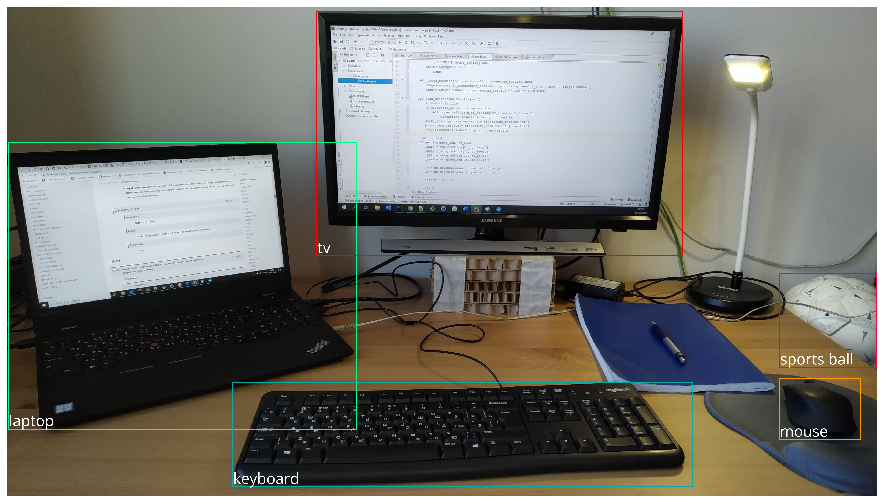

In [10]:
sample_ds.show_images(with_annotations=True)

Модель уже была протестирована с помощью этого датасета заранее, и были сохранены результаты работы модели

In [11]:
path_to_processing_results = 'fasterrcnn_resnet50_desktopco.txt'
path_to_processed_files_filenames = 'desktopco_processed_files_filenames.txt'

Для чтения файлов понадобится библиотека pickle

In [12]:
import pickle

Загрузим эти результаты в специальную структуру данных - ObjectDetectionResults

In [13]:
from cvints.processing_results import ObjectDetectionResults

In [14]:
raw_processing_results = ObjectDetectionResults()

In [15]:
with open(path_to_processing_results, "rb") as fp:  # Unpickling
    raw_processing_results_data = pickle.load(fp)

In [16]:
with open(path_to_processed_files_filenames, 'rb') as in_file:
    processed_images_filenames = pickle.load(in_file)

raw_processing_results_data - это list of dicts, внутри каждого словаря результаты обработки каждого изображения из датасета, который был подан на вход модели. В этом списке они записаны без привязки к имени файлов или каких-то id, поэтому мы также заранее сохранили список имен файлов изображений в том же порядке, в каком они были обработаны моделью, для идентификации и сопоставления результатов обработки и исходных изображений из объекта класса (или унаследованного от класса) Dataset.

Поэтому теперь извлечём из экземпляра объекта класса (или унаследованного от класса) Dataset информацию о изображениях в том же порядке, в каком они были обработаны моделью.

In [17]:
processed_images_info = dataset.get_images_info_by_filenames(processed_images_filenames)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3004.52it/s]


Загрузим всё, что мы знаем об обработанных изображениях в экземпляр соответствующего объекта

In [18]:
raw_processing_results.load_results(raw_processing_results_data, processed_images_info)

Опишем, какая модель обрабатывала изображения. <br>
Для этого через config зазадим параметры модели и передадим их в объект соответствующего класса

In [19]:
from cvints.model import ObjectDetectionModel

In [20]:
model_config = {'name': 'fasterrcnn_resnet50',  # имя модели для идентификации 
                'input_size': (300, 300),  # размер изображений, которые принимает модель на вход
                                           # необходимо для масштабирования спрогнозированных bbox 
                                           # на оригинальный размер изображений 
                'NMS': False  # Показываем, что Non-maximum suppression к результатам не применялась и 
                              # это ещё вероятно нужно проделать
               }
model = ObjectDetectionModel(config=model_config)

Следующее действие как бы прогонит результаты через модель, чтобы восстановить bbox до оригинального размера изображений, а также сгруппирует внутри результатов каждого изображения детекции по категориям

In [21]:
processing_results = model.set_processing_results(raw_processing_results)

Мы готовы создать экземпляр класса Experiment, который объединит ранее созданные сущности. <br>
- Задача какого класса решается - <b>task</b>
- Какую модель изучаем - <b>model</b>
- С помощью какого датасета - <b>dataset</b>
- Обрабатываемые результаты работы модели - <b>processing_results</b>

In [22]:
from cvints.experiment import Experiment

In [23]:
experiment = Experiment(task, model, dataset, processing_results)

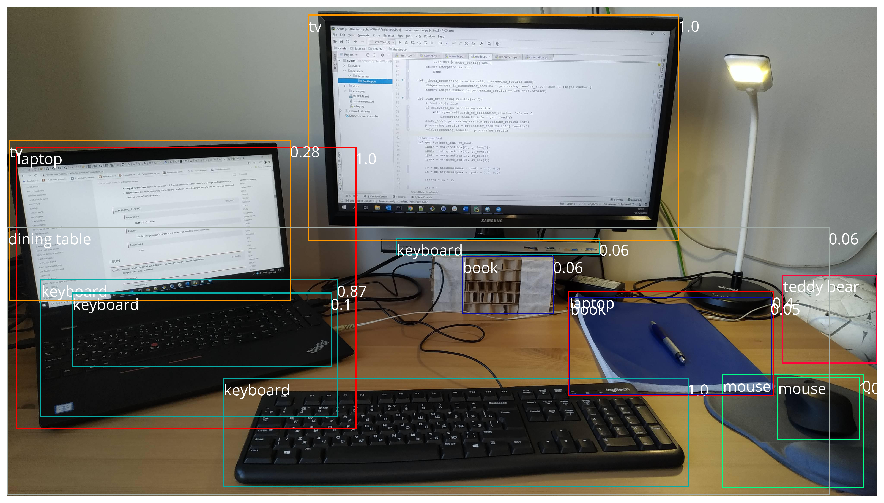

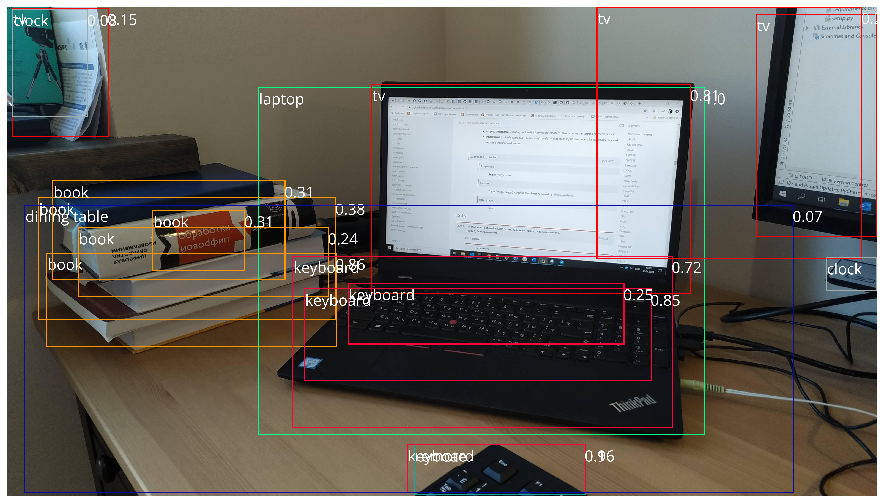

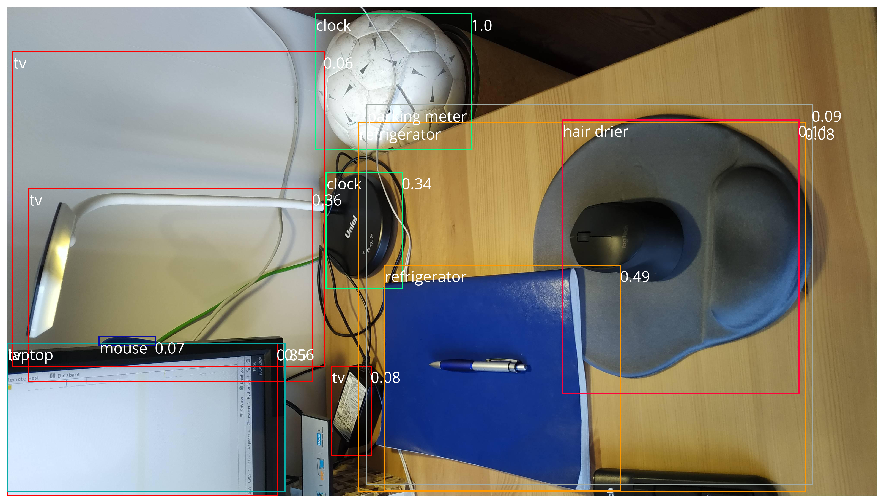

In [24]:
experiment.show_images()

Мы видимо, что в результатах работы модели без пост-процессинга много мусора. 

Применим фильтрацию по scores и посмотрим, что останется

In [25]:
experiment.filter_results_by_scores(scores_threshold=0.5)

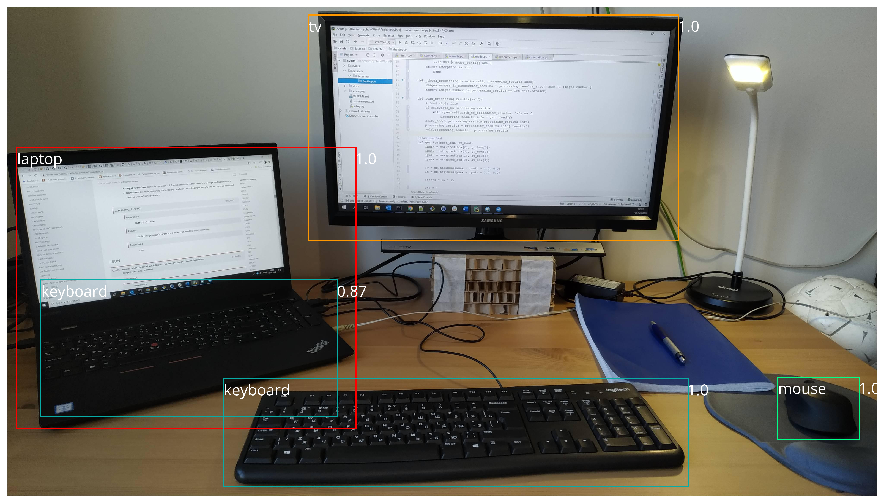

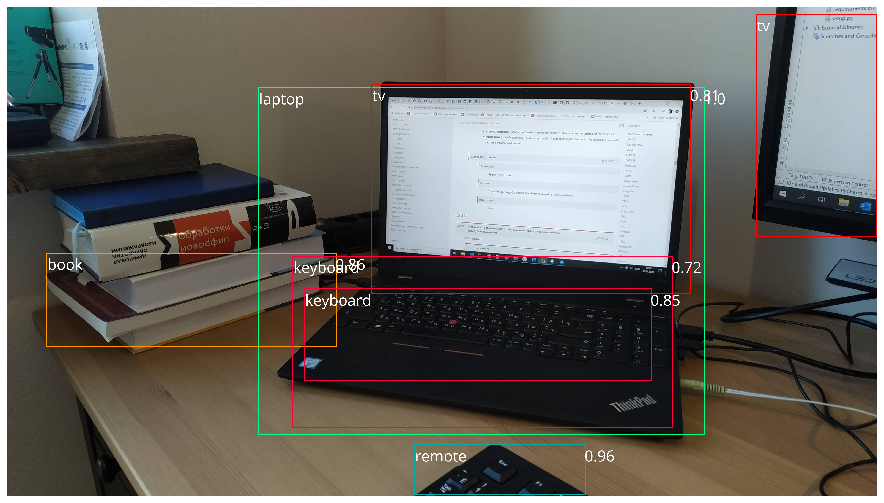

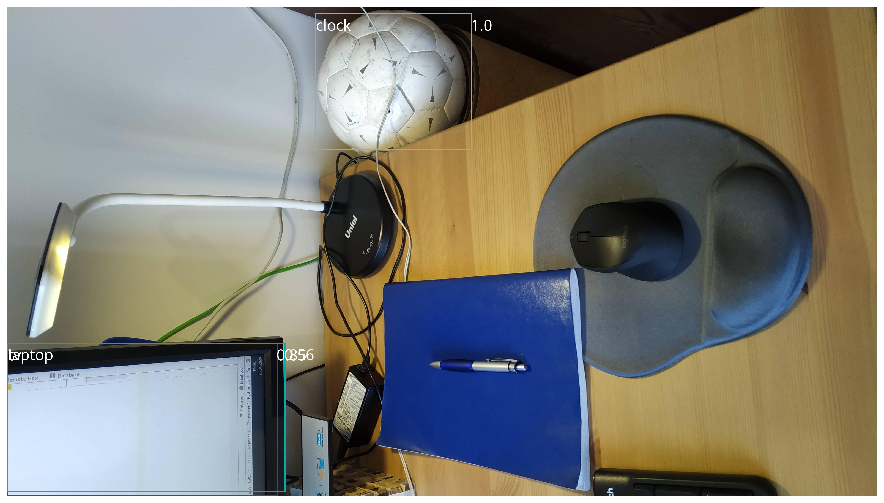

In [26]:
experiment.show_images()

Уже лучше, теперь попробуем применить NMS с порогом пересечения 0.5; то есть, если две детекции объекта одного класса пересекаются больше чем на 15% (IoU > 0.15), из двух детекций остаётся только одна с наибольшим score.

In [27]:
experiment.apply_nms(nms_threshold=0.15)

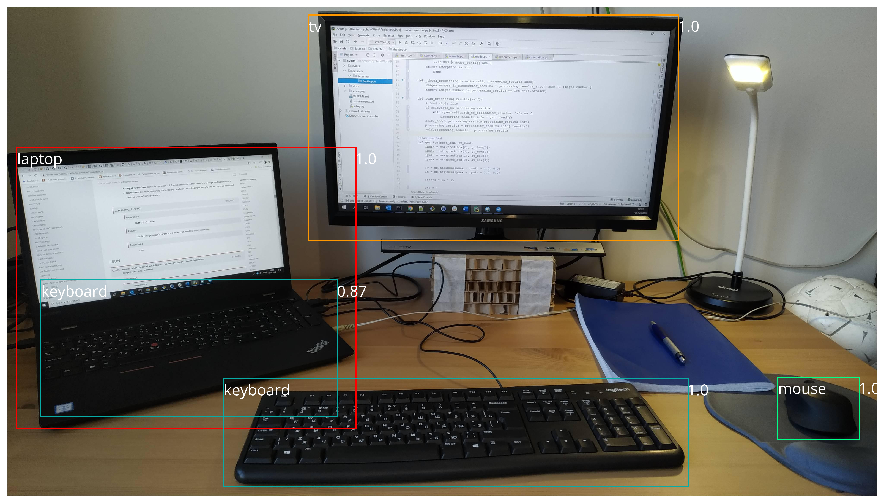

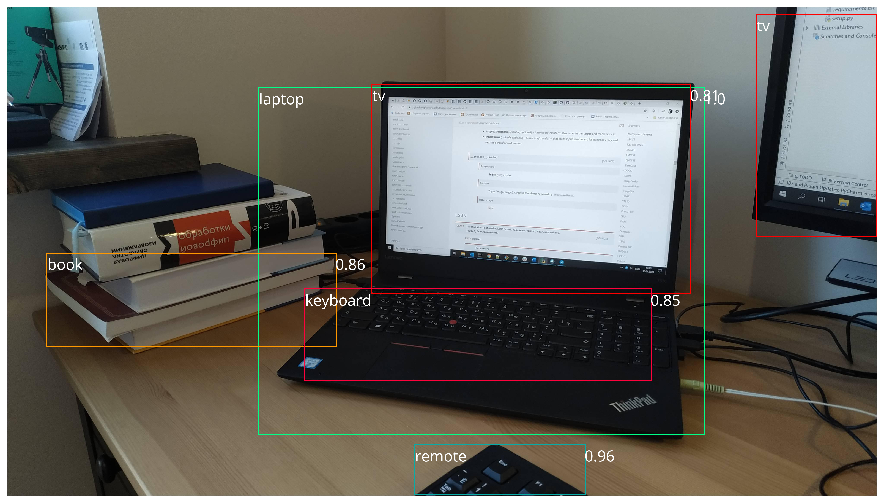

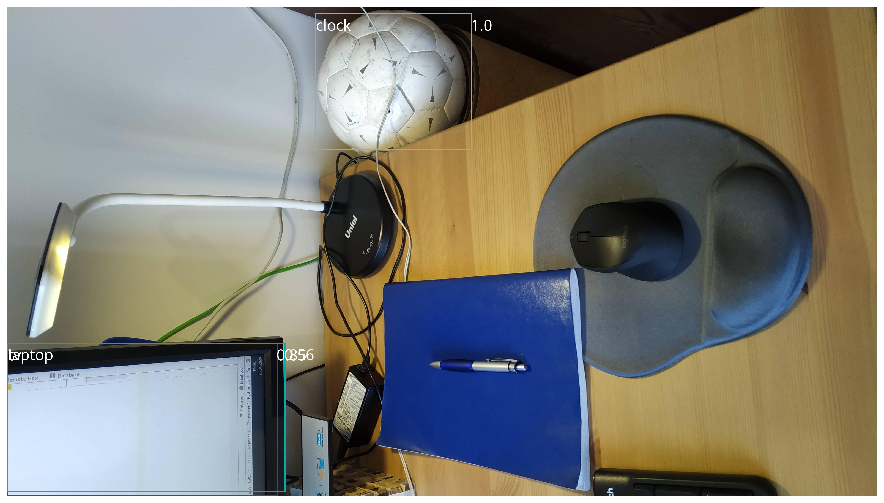

In [28]:
experiment.show_images()

Теперь подсчитаем метрики для получившихся результатов

In [33]:
experiment.metrics = ['TP', 'FP', 'FN']

In [34]:
experiment.metrics.calculate()

defaultdict(collections.defaultdict,
            {'TP': defaultdict(int,
                         {'sports ball': 0,
                          'tv': 3,
                          'book': 0,
                          'keyboard': 1,
                          'mouse': 1,
                          'laptop': 2}),
             'FP': defaultdict(int,
                         {'sports ball': 0,
                          'tv': 1,
                          'book': 1,
                          'keyboard': 2,
                          'mouse': 0,
                          'laptop': 1}),
             'FN': defaultdict(int,
                         {'sports ball': 2,
                          'tv': 0.0,
                          'book': 0.0,
                          'keyboard': 1,
                          'mouse': 1,
                          'laptop': 0.0})})

In [35]:
experiment.metrics.print_values()

Metric is TP
{'book': 0, 'keyboard': 1, 'laptop': 2, 'mouse': 1, 'sports ball': 0, 'tv': 3}
Metric is FP
{'book': 1, 'keyboard': 2, 'laptop': 1, 'mouse': 0, 'sports ball': 0, 'tv': 1}
Metric is FN
{'book': 0.0,
 'keyboard': 1,
 'laptop': 0.0,
 'mouse': 1,
 'sports ball': 2,
 'tv': 0.0}


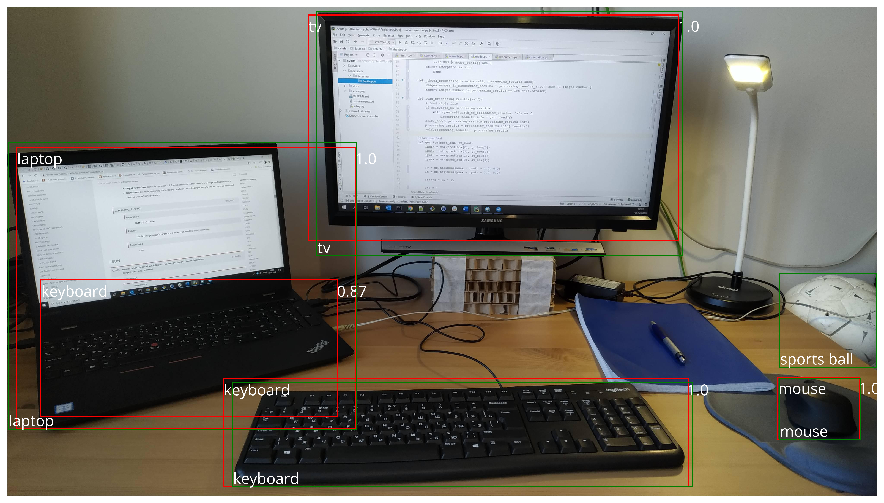

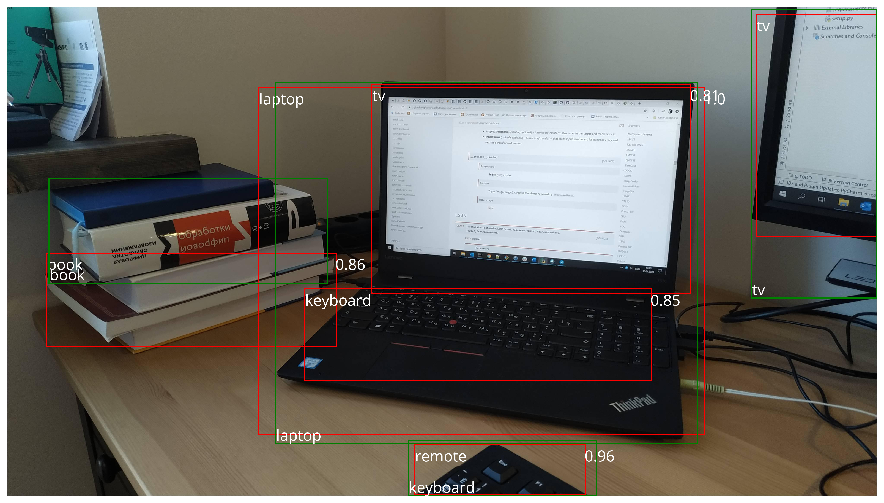

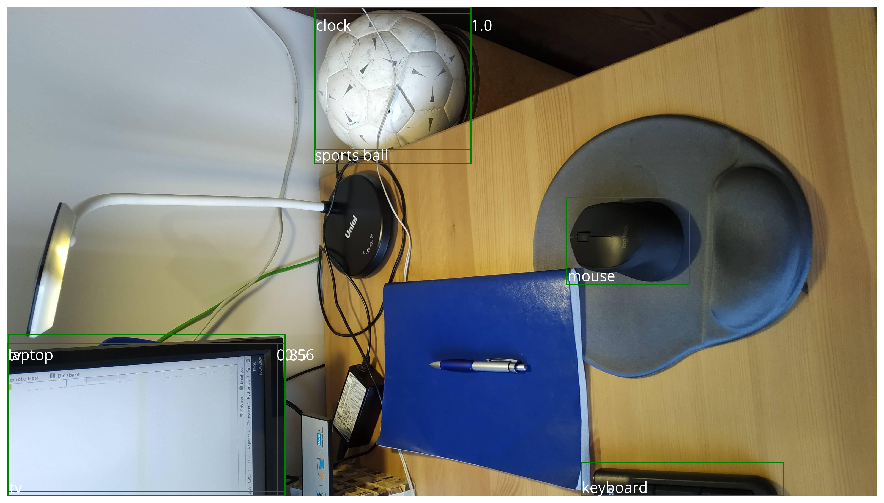

In [32]:
experiment.show_prediction_on_images()